In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler, scale
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, train_test_split, LeaveOneOut, KFold
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from numpy import logspace, random
import pickle
from scipy.stats import rankdata
from os.path import basename

import shap

from sklearn.ensemble import RandomForestRegressor
import TraitData
from imp import reload
import seaborn as sns
reload(TraitData)
sns.set()
sns.set(font_scale=1.5)

cv = KFold(n_splits=10)
# try:
#     SAVED_STATE = pickle.load(open("np.random.state", 'rb'))
#     np.random.set_state(SAVED_STATE)
# except Exception as e:
#     SAVED_STATE = False
    

%matplotlib inline
plt.rcParams['figure.figsize'] = (7,15)
%config InlineBackend.figure_format = 'retina'

<img style="float:right" src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png" width=60px)/>
<h1> Feature Interpretation Across Methods: A Study <small> Tony Cannistra | CSE546 Au17 Final Project </small></h1>
We are attempting to understand the type and magnitude of the effects that various physiological or behavioral traits have had on historical range shifts.

The challenge is that standard linear regression has been only able to explain a small percentage of the variance seen in range shift data for several taxa ([Angert et al., 2011](http://onlinelibrary.wiley.com/doi/10.1111/j.1461-0248.2011.01620.x/abstract)). This is likely as a result of the relationships between predictor and response variables being something other than linear, especially since several variables have biological relevance for their ability to facilitate range shifts. 

## Load Data + Define Functions
For this exploration we have trait data for several large taxonomic groups of organisms and their observed range shifts over the past 100 years. There are 3 datasets
### Define Each Dataset

In [2]:
plantsData = {
    'file' : "../data/angert_etal_2011/plants5.csv",
    
    'responseVar'   : "migration_m",

    'drop_features' : ["Taxon",
                     "migr_sterr_m", 
                     "shift + 2SE", 
                     'signif_shift',
                     "signif_shift2",
                     "dispmode01",
                     "DispModeEng", ## what is this
                     "shift + 2SE", 
                      "Grime"],
    'categorical_features' : ["oceanity",
                            "dispersal_mode",
                            "BreedSysCode"]
}

mammalData = {
    'file' : "../data/angert_etal_2011/mammals01.csv",
    
    'responseVar'   : "High_change",

    'drop_features' : ["Taxon",
                       "High_change_pfa2",
                       "Daily_rhythm_code",
                       "Annual_rhythm_code"],
    
    'categorical_features' : ["Daily01",
                              "Annual01",
                              "Food01",
                              "Daily_rhythm",
                              "Annual_rhythm",
                              "Food"]
}

triennialMarineData = {
    'file' : "../data/marine/west-coast-triennial _species_generaltraits.csv",
    'responseVar' : "Latitudinal Difference",
    
    'drop_features' : ["Species", "Latitudinal Std",
                      "FamCode", "GenCode"], 
    
    'categorical_features' : [
        "UsedforAquaculture",
        "Electrogenic",
        "DemersPelag",
        "LTypeMaxM", 
        "Fresh", 
        "Brack", 
        "Saltwater"
    ]
}

rankings = []
MSEs = []


### Select, Load, and Normalize Dataset

In [3]:
dataset = triennialMarineData
dsname = basename(dataset['file'])
dropNA  = 0

td = TraitData.TraitData(dataset['file'],
                         dataset['responseVar'],
                         dataset['drop_features'],
                         dataset['categorical_features'],
                         dropNA=dropNA, scale=True)
print(len(td.X))
display(td.X.head())
td.X = np.array(td.X)
td.Y = np.array(td.Y)

print(td.X.shape)
print(td.feature_names)



76


/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


,DepthRangeDeep,Vulnerability,Length,UsedforAquaculture_commercial,UsedforAquaculture_likely future use,UsedforAquaculture_never/rarely,Electrogenic_Electrosensing only,Electrogenic_electrosensing only,Electrogenic_no special ability,Electrogenic_strongly discharging,...,DemersPelag_pelagic-oceanic,DemersPelag_reef-associated,LTypeMaxM_FL,LTypeMaxM_SL,LTypeMaxM_TL,Fresh_-1,Fresh_0,Brack_-1,Brack_0,Saltwater_-1
0,-1.080200,-1.473061,-0.817193,0,0,1,0,0,1,0,...,0,0,0,0,1,0,1,0,1,1
1,-0.798251,-0.248015,-0.017934,0,0,1,0,0,1,0,...,0,0,0,0,1,1,0,1,0,1
2,3.977626,0.079575,0.644353,0,1,0,0,0,1,0,...,0,0,0,0,1,0,1,0,1,1
3,1.227181,-0.138601,-0.123297,0,0,1,1,0,0,0,...,0,0,0,0,1,0,1,0,1,1
4,0.544365,0.591477,0.102482,0,0,1,0,0,1,0,...,0,0,0,0,1,0,1,0,1,1


(76, 25)
['DepthRangeDeep', 'Vulnerability', 'Length', 'UsedforAquaculture_commercial', 'UsedforAquaculture_likely future use', 'UsedforAquaculture_never/rarely', 'Electrogenic_Electrosensing only', 'Electrogenic_electrosensing only', 'Electrogenic_no special ability', 'Electrogenic_strongly discharging', 'Electrogenic_weakly discharging', 'DemersPelag_bathydemersal', 'DemersPelag_benthopelagic', 'DemersPelag_demersal', 'DemersPelag_pelagic-neritic', 'DemersPelag_pelagic-oceanic', 'DemersPelag_reef-associated', 'LTypeMaxM_FL', 'LTypeMaxM_SL', 'LTypeMaxM_TL', 'Fresh_-1', 'Fresh_0', 'Brack_-1', 'Brack_0', 'Saltwater_-1']


In [4]:
pickle.dump(np.random.get_state(), open('np.random.state', 'wb'), )
X_train, X_test, Y_train, Y_test = train_test_split(td.X, td.Y, train_size=0.60)

/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Learning

In [5]:
## Importance Plotting Function
def plot_importance(importances, names, title=None, std=None, ft="", save=None):
    sns.set()
    sns.set(font_scale=1.5)
    plt.rcParams['figure.figsize'] = (7,15)
    f, ax = plt.subplots()
    
    bar_indices = np.arange(len(names))
    bar_width = 0.45
    importances_ind = np.argsort(abs(importances))

    plt.barh(bar_indices,
             importances[importances_ind],
            align='center', color='#4b2e83', xerr=std)
    
    plt.figtext(1, 0, ft, ha='right')
    plt.yticks(bar_indices, np.array(names)[importances_ind])
    plt.title(title)
    plt.tight_layout()
    if(save is not None):
        plt.savefig(save, bbox='tight', dpi=200)
    plt.show()
    
def compute_ranks(importances, absolute=True):
    if absolute:
        sorted_idx =  abs(importances).argsort()[::-1]
    else:
        sorted_idx = importances.argsort()[::-1]
    return(np.arange(len(importances))[sorted_idx.argsort()])

### Linear Models
#### OLS

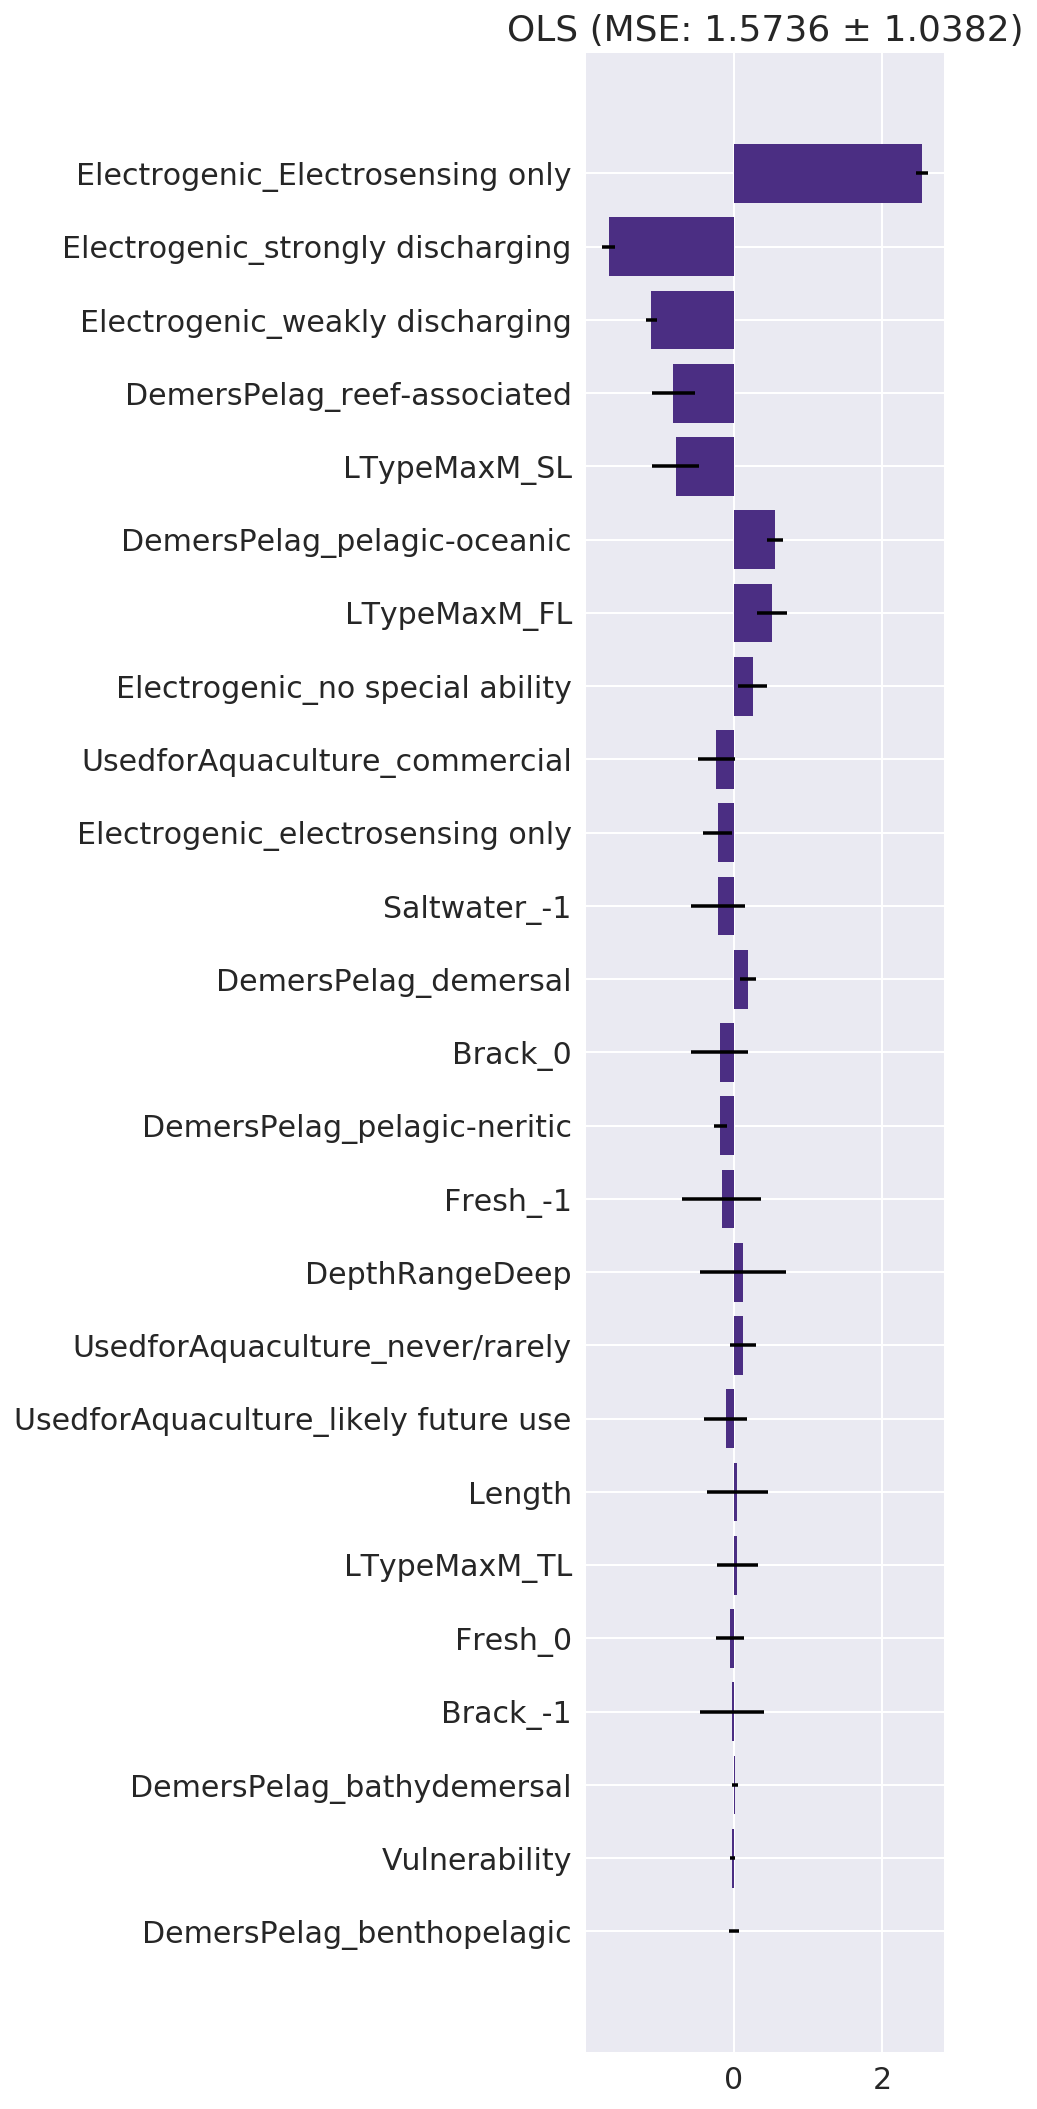

In [6]:
ols_coefs = []
ols_mses = []
for train, test in cv.split(td.X, td.Y):
    ols = LinearRegression(fit_intercept=False, normalize=False)
    ols.fit(td.X[train], td.Y[train])
    preds = ols.predict(td.X[test])
    error = mean_squared_error(td.Y[test], preds)
    ols_mses.append(error)
    ols_coefs.append(ols.coef_)
    
mean_error = np.mean(ols_mses)
std_error = np.std(ols_mses)
mean_coefs = np.mean(ols_coefs, axis=0)
std_coefs = np.std(ols_coefs, axis=0)

plot_importance(mean_coefs,
                td.feature_names, "OLS (MSE: %1.4f ± %1.4f)" % (mean_error, std_error),
                std=std_coefs, save="{}_ols-ranks.png".format(dsname))
MSEs.append(("OLS", ols_mses))
rankings.append(['OLS'] + list(compute_ranks(mean_coefs)))


#### Ridge CV

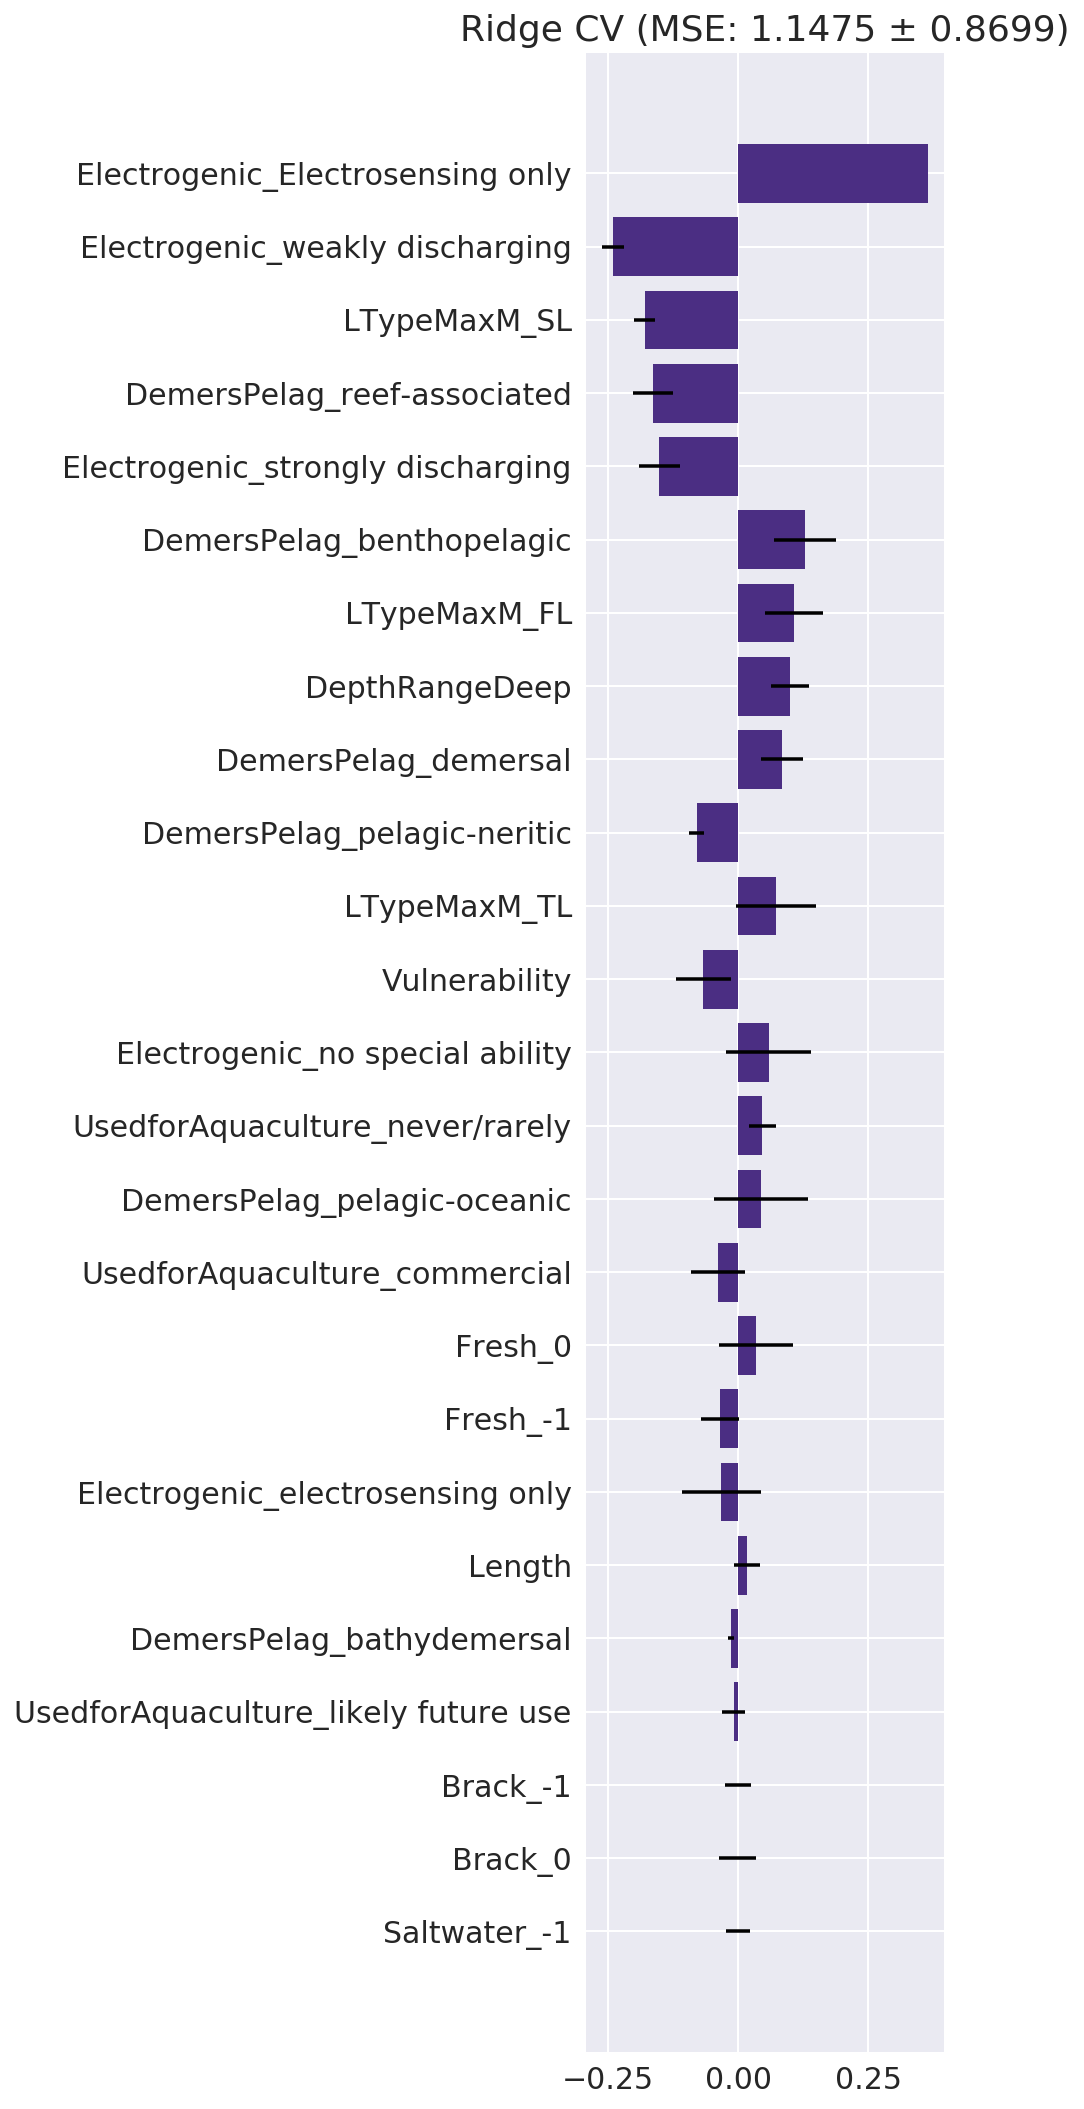

In [7]:
ridge_coefs = []
ridge_mses = []
for train, test in cv.split(td.X, td.Y):
    ridgecv = RidgeCV(normalize=False)
    ridgecv.fit(td.X[train], td.Y[train])
    preds = ridgecv.predict(td.X[test])
    error = mean_squared_error(td.Y[test], preds)
    ridge_mses.append(error)
    ridge_coefs.append(ridgecv.coef_)
    
mean_error = np.mean(ridge_mses)
std_error = np.std(ridge_mses)
mean_coefs = np.mean(ridge_coefs, axis=0)
std_coefs = np.std(ridge_coefs, axis=0)

    
plot_importance(mean_coefs, td.feature_names,  "Ridge CV (MSE: %1.4f ± %1.4f)" % (mean_error, std_error), std=std_coefs,
               save="{}_ridge-ranks.png".format(dsname))
rankings.append(['Ridge'] + list(compute_ranks(mean_coefs)))
MSEs.append(("Ridge", ridge_mses))


#### Kernel Ridge

In [8]:
kernel_ridge_coefs = []
kernel_ridge_mses = []
for train, test in cv.split(td.X, td.Y):
    kr = KernelRidge(kernel='rbf')
    kr.fit(td.X[train], td.Y[train])
    preds = kr.predict(td.X[test])
    error = mean_squared_error(td.Y[test], preds)
    shapdata = shap.DenseData(td.X[train], td.feature_names)
    explainer = shap.KernelExplainer(kr.predict, shapdata, nsamples=100)
    kernel_ridge_coefs.append(explainer.explain(np.mat(td.X[test])).effects)
    kernel_ridge_mses.append(error)
    
#     for i in range(0, len(X_test)-1):
#         try: 
#             explanations.append(explainer.explain(np.mat(td.X[test][i:i+1, :])))
#         except Exception as e:
#             print("error on ", (i, i+1))
#             print(e)
#             continue



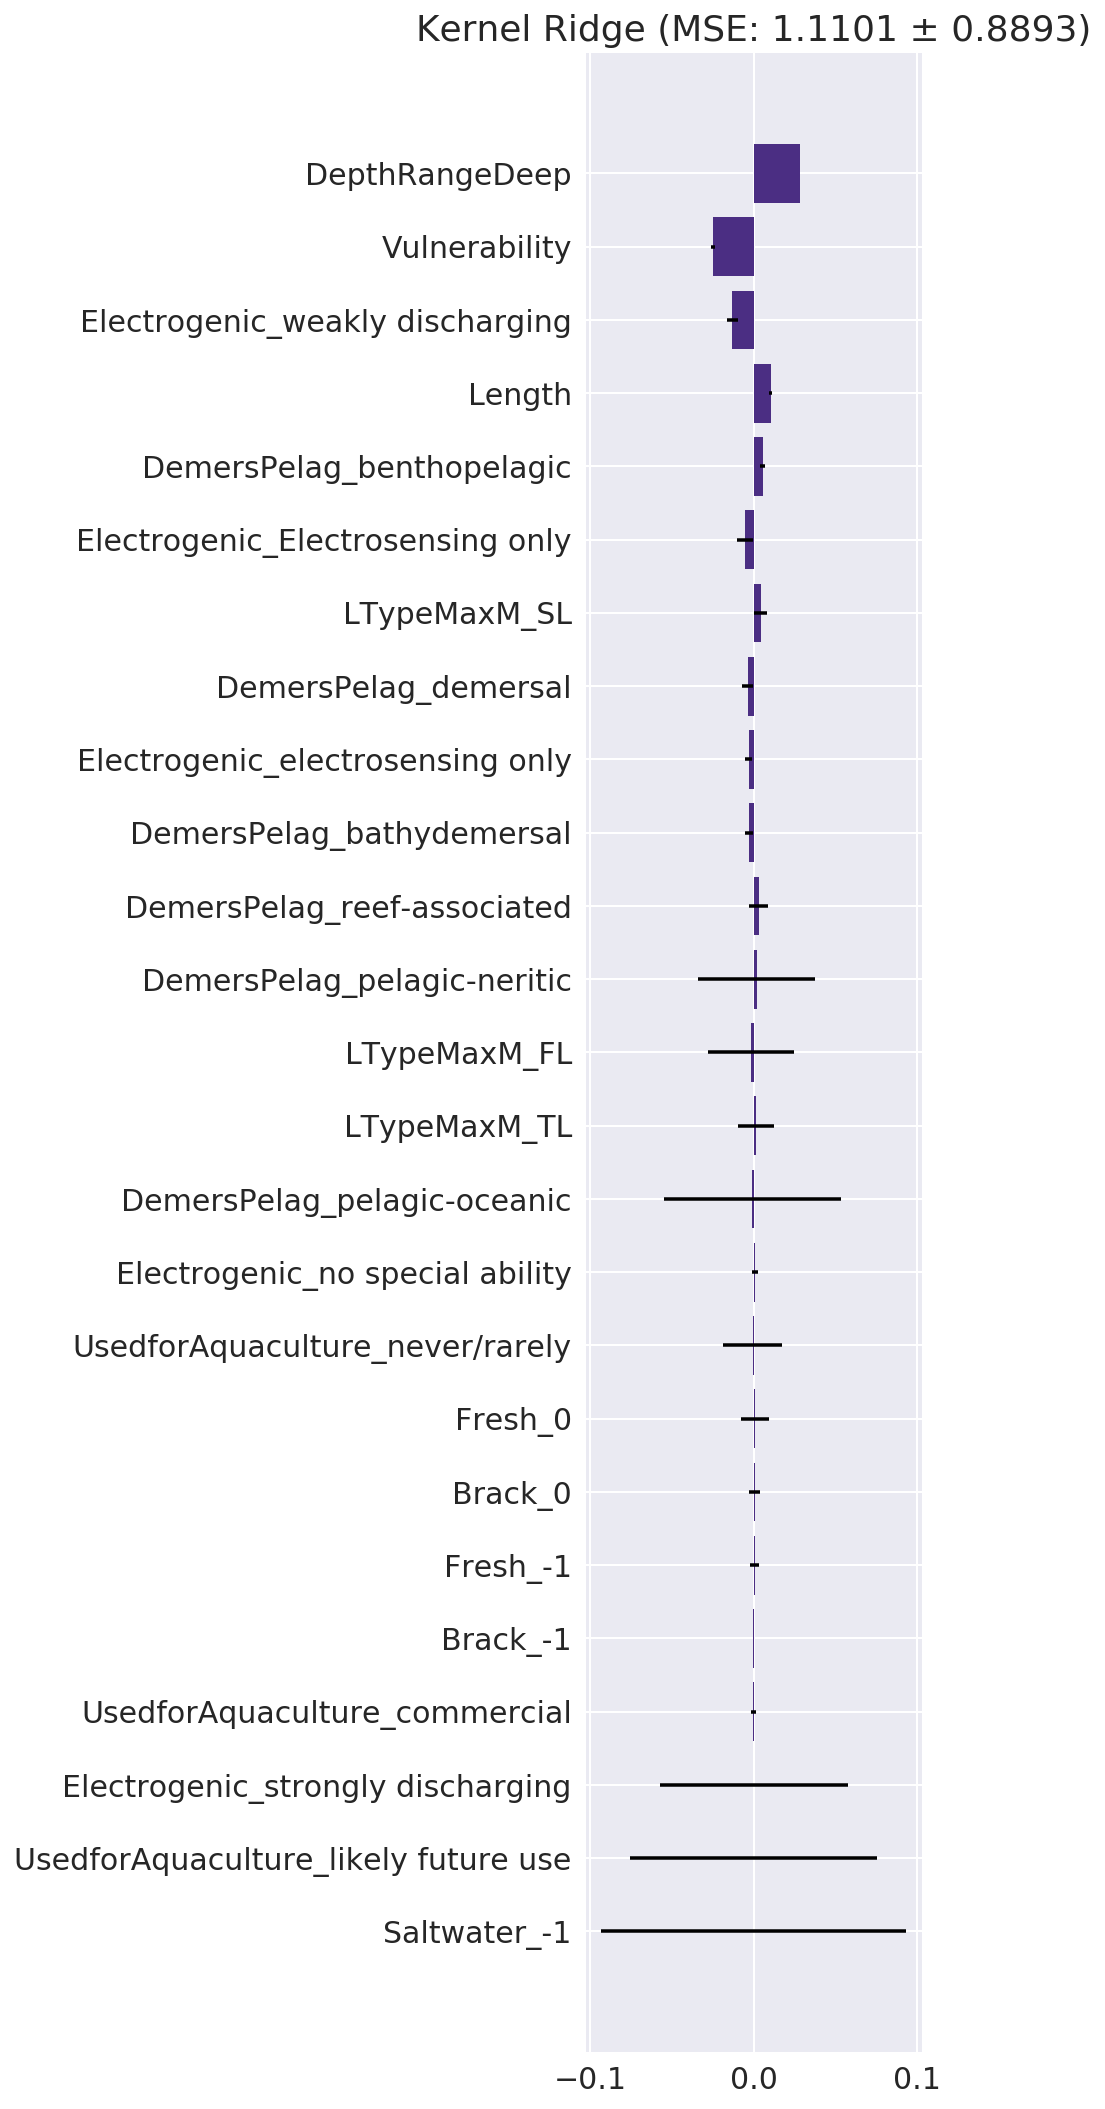

In [9]:
mean_error = np.mean(kernel_ridge_mses)
std_error = np.std(kernel_ridge_mses)
mean_coefs = np.mean(kernel_ridge_coefs, axis=0)
std_coefs = np.std(kernel_ridge_coefs, axis=0)
plot_importance(mean_coefs, td.feature_names, "Kernel Ridge (MSE: %1.4f ± %1.4f)" % (mean_error, std_error), 
               std=std_coefs, save="{}_kernelridge-ranks.png".format(dsname))
MSEs.append(("Kernel Ridge", kernel_ridge_mses))

rankings.append(['Kernel Ridge'] + list(compute_ranks(mean_coefs)))

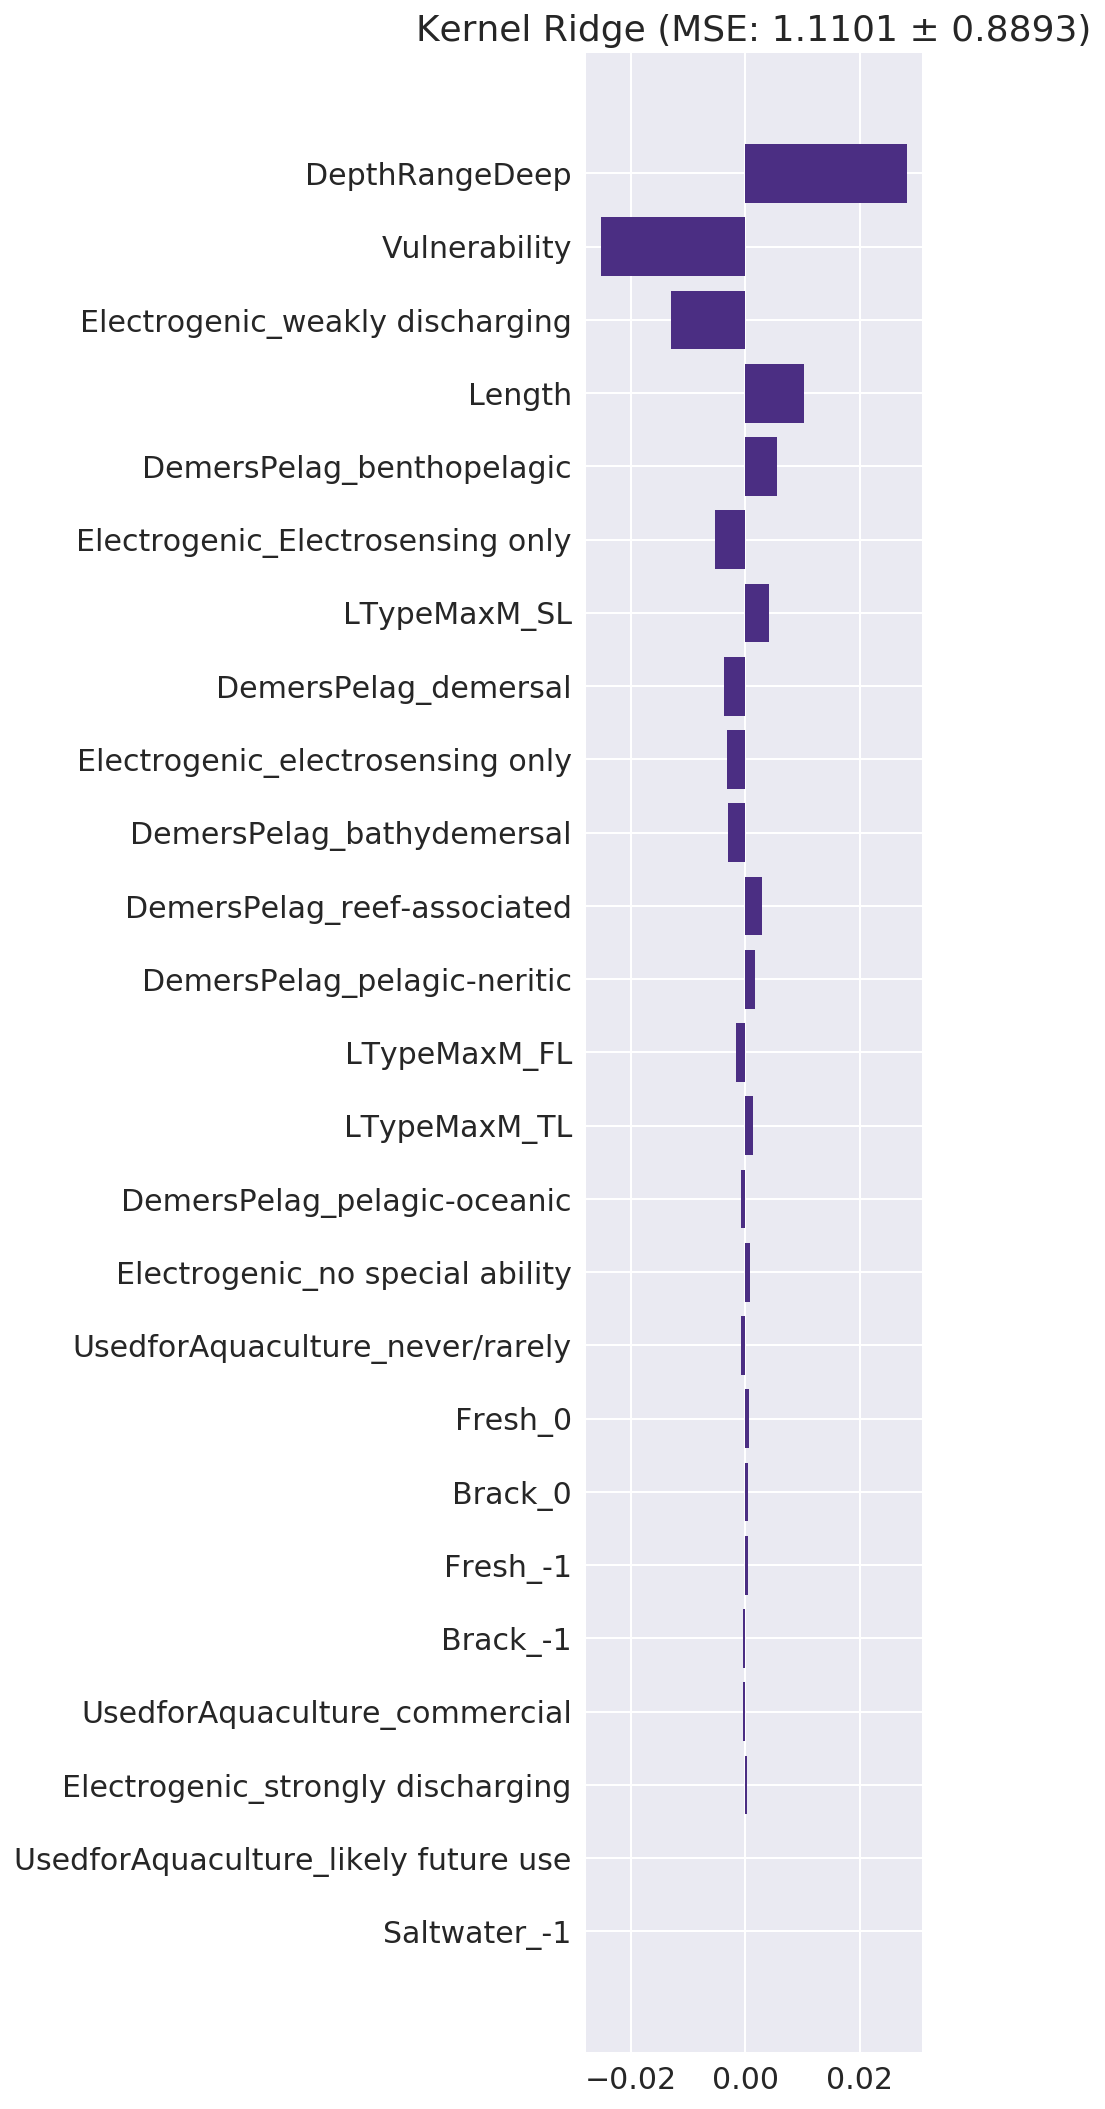

In [10]:
plot_importance(mean_coefs,
                td.feature_names,
                "Kernel Ridge (MSE: %1.4f ± %1.4f)" % (mean_error, std_error), save="{}_kernelridge-nostd-ranks.png".format(dsname))
                #std=std_coefs)

rankings.append(['Kernel Ridge'] + list(compute_ranks(mean_coefs)))

### Trees

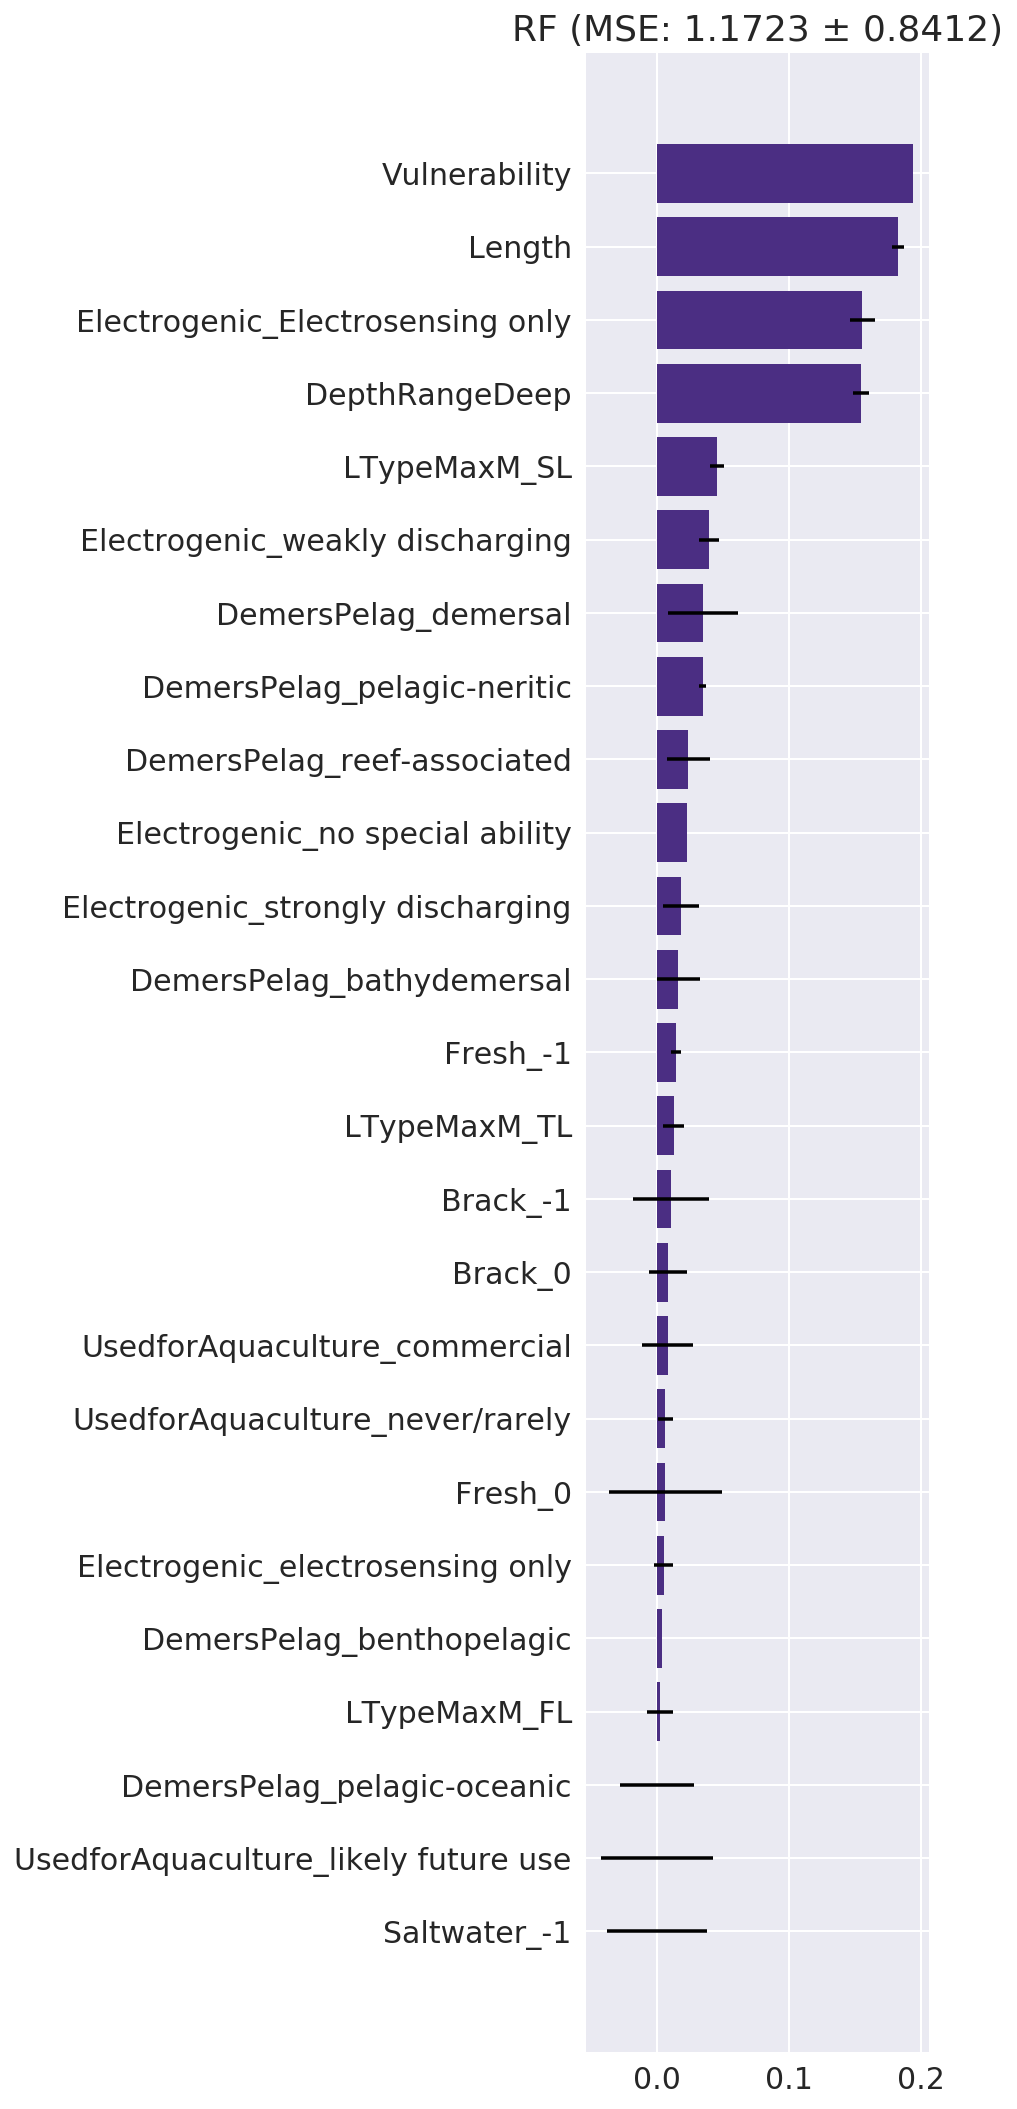

In [11]:
rf_coefs = []
rf_mses = []
for train, test in cv.split(td.X, td.Y):    
    rf = RandomForestRegressor()
    rf.fit(td.X[train], td.Y[train])
    preds = rf.predict(td.X[test])
    error = mean_squared_error(td.Y[test], preds)
    rf_mses.append(error)
    rf_coefs.append(rf.feature_importances_)

mean_error = np.mean(rf_mses)
std_error = np.std(rf_mses)
mean_coefs = np.mean(rf_coefs, axis=0)
std_coefs = np.std(rf_coefs, axis=0)
    
MSEs.append(("RF", rf_mses))
plot_importance(mean_coefs,
                td.feature_names, "RF (MSE: %1.4f ± %1.4f)" % (mean_error, std_error),
                std=std_coefs, 
                save="{}_rf-ranks.png".format(dsname))
rankings.append(['RF'] + list(compute_ranks(rf.feature_importances_)))

### Support Vectors

In [12]:
baseModel = SVR()
params_grid = {
    'C'     : np.logspace(-3, 1.2),
    'gamma' : np.logspace(-3, 1.2),
    'degree': [0, 1, 2],
    'kernel': ['linear', 'poly', 'rbf']
}
gridSearch = GridSearchCV(baseModel,
                         param_grid = params_grid,
                         scoring="neg_mean_squared_error",
                         error_score = 0,
                         n_jobs = -1)

svr_coefs = []
svr_mses = []



for train, test in list(cv.split(td.X, td.Y)):   
    print("CV Run Init")
    gridSearch.fit(td.X[train], td.Y[train])
    best = gridSearch.best_estimator_
    preds = gridSearch.best_estimator_.predict(td.X[test])
    error = mean_squared_error(preds, td.Y[test])
    svr_mses.append(error)
    shapdata = shap.DenseData(X_train, td.feature_names)
    explainer = shap.KernelExplainer(best.predict, shapdata, nsamples=100)
    svr_coefs.append(explainer.explain(np.mat(td.X[test])).effects)


CV Run Init
CV Run Init
CV Run Init
CV Run Init
CV Run Init
CV Run Init
CV Run Init
CV Run Init
CV Run Init
CV Run Init


KeyboardInterrupt: 

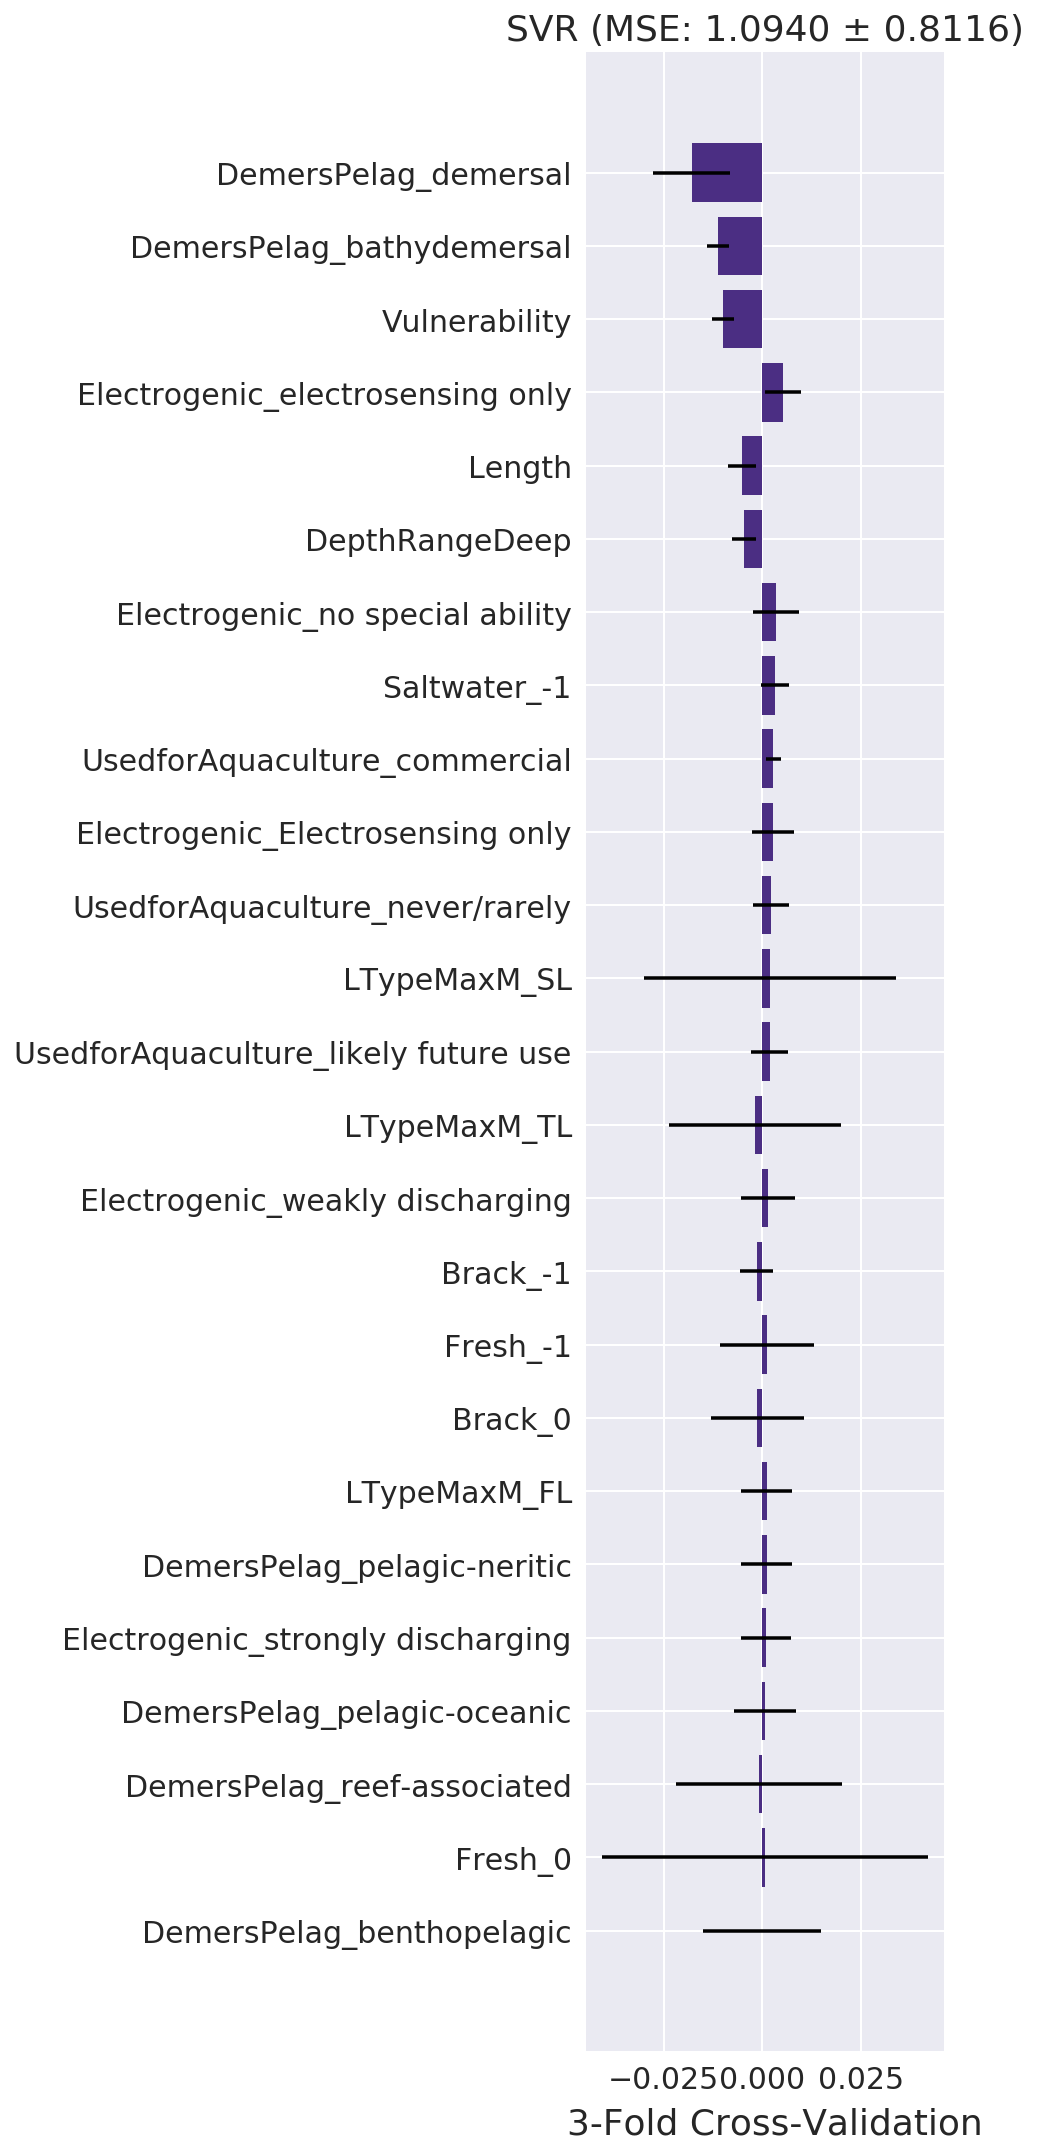

In [13]:
mean_error = np.mean(svr_mses)
std_error = np.std(svr_mses)
mean_coefs = np.mean(svr_coefs, axis=0)
std_coefs = np.std(svr_coefs, axis=0)



MSEs.append(("SVR", svr_mses))
plot_importance(mean_coefs,
                td.feature_names, "SVR (MSE: %1.4f ± %1.4f)" % (mean_error, std_error), ft="3-Fold Cross-Validation",
                std=std_coefs, save="{}_svr-ranks.png".format(dsname))
rankings.append(['SVR'] + list(compute_ranks(mean_coefs)))

In [15]:
results = pd.DataFrame(rankings, columns=["Method"] + td.feature_names).set_index("Method").T
results['mean'] = results.mean(axis=1)


In [16]:
results.sort_values(by=['mean'])

Method,OLS,Ridge,Kernel Ridge,Kernel Ridge,RF,SVR,mean
Electrogenic_Electrosensing only,0,0,5,5,0,9,3.166667
Electrogenic_weakly discharging,2,1,2,2,4,14,4.166667
DepthRangeDeep,15,7,0,0,2,5,4.833333
LTypeMaxM_SL,4,2,6,6,7,11,6.000000
Vulnerability,23,11,1,1,1,2,6.500000
DemersPelag_demersal,11,8,7,7,8,0,6.833333
Length,18,19,3,3,3,4,8.333333
DemersPelag_reef-associated,3,3,10,10,6,22,9.000000
Electrogenic_electrosensing only,9,18,8,8,18,3,10.666667
DemersPelag_pelagic-neritic,13,9,11,11,5,19,11.333333


In [17]:
results.to_csv("{}-rank.csv".format(dsname))
from pandas.tools.plotting import table


/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 'pandas.tools.plotting.table' is deprecated, import 'pandas.plotting.table' instead.
  


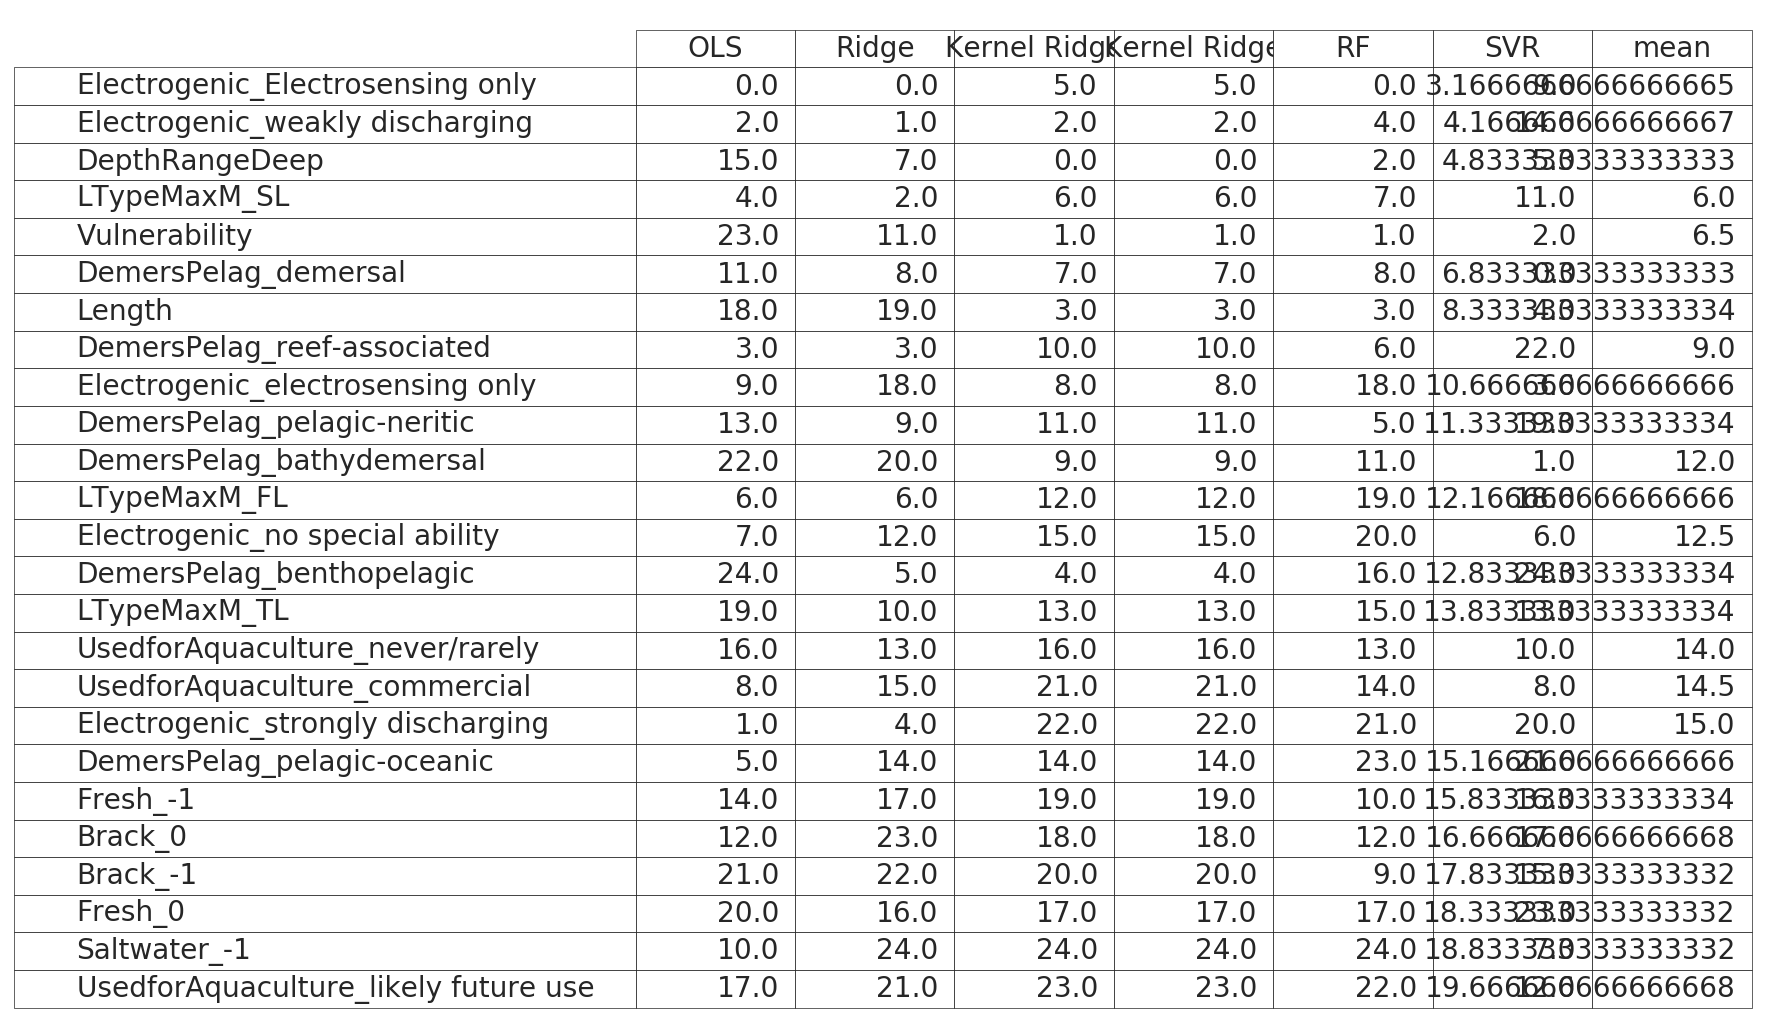

In [18]:
results = results.sort_values(by='mean')
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
tab = table(ax, results, loc='upper left')
tab.auto_set_font_size(False)
tab.set_fontsize(14)
tab.scale(1.2, 1.3)
fig.tight_layout()

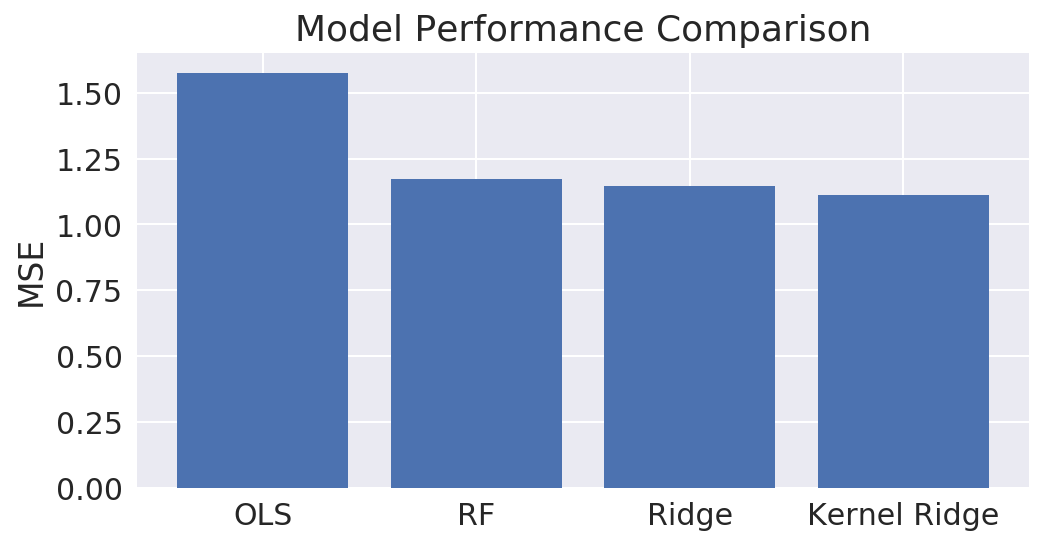

In [52]:

fig = plt.figure(figsize=(8, 4))
labels, errors = zip(*MSEs)
errors = np.array(errors)
error_means = np.mean(errors, axis=1)
error_stds = np.std(errors, axis=1)
labels = np.array(labels)
sorted_idx = np.argsort(error_means)[::-1]
plt.bar(range(0, len(MSEs)), error_means[sorted_idx])
plt.xticks(range(0, len(MSEs)), labels[sorted_idx])
plt.ylabel("MSE")
plt.title("Model Performance Comparison")
plt.savefig("{}-msecompare.png".format(dsname), dpi=200)

In [50]:
from itertools import combinations
msedict = dict(MSEs)
list(combinations(msedict.keys(), 2))

[('OLS', 'Ridge'),
 ('OLS', 'Kernel Ridge'),
 ('OLS', 'RF'),
 ('Ridge', 'Kernel Ridge'),
 ('Ridge', 'RF'),
 ('Kernel Ridge', 'RF')]

In [51]:
from scipy.stats import ttest_rel
significance = list(map(lambda x: (x, ttest_rel(msedict[x[0]], msedict[x[1]]).pvalue), combinations(msedict.keys(),2)))
significance = pd.DataFrame(significance, columns=["Combination", "pvalue"])
significance

,Combination,pvalue
0,"(OLS, Ridge)",0.038009
1,"(OLS, Kernel Ridge)",0.031129
2,"(OLS, RF)",0.056166
3,"(Ridge, Kernel Ridge)",0.028126
4,"(Ridge, RF)",0.769789
5,"(Kernel Ridge, RF)",0.476948


In [ ]:
from scipy.stats import ttest_rel
ttest_rel(msedict['Kernel Ridge']).pvalue